In [1]:
cd C:\\Users\\Sharuka Thirimanne\\Desktop\\FYP-ML-IDS

C:\Users\Sharuka Thirimanne\Desktop\FYP-ML-IDS


In [2]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.decomposition import PCA
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from tensorflow.keras import Model, layers
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
scaler = MinMaxScaler()

c:\users\sharuka thirimanne\appdata\local\programs\python\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\sharuka thirimanne\appdata\local\programs\python\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\sharuka thirimanne\appdata\local\programs\python\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
def load_train_dataset():
    df_train = pd.read_csv('Datasets/UNSW_train-set.csv')
    df_train.drop(['index'], axis = 'columns' , inplace = True)
    df_train.drop(['attack_cat'], axis = 'columns' , inplace = True)
    
    
    for col in ['proto','service','state']:
        df_train[col] = df_train[col].astype('category')
        
    others1 = df_train['proto'].value_counts().index[8:]
    label = 'Other'
    # apply new category label
    df_train['proto'] = df_train['proto'].cat.add_categories([label])
    df_train['proto'] = df_train['proto'].replace(others1, label)
    
    others3 = df_train['service'].value_counts().index[8:]
    # apply new category label
    df_train['service'] = df_train['service'].cat.add_categories([label])
    df_train['service'] = df_train['service'].replace(others3, label)
    
    others5 = df_train['state'].value_counts().index[4:]
    # apply new category label
    df_train['state'] = df_train['state'].cat.add_categories([label])
    df_train['state'] = df_train['state'].replace(others5, label)
    
    df_train.drop_duplicates(keep='first',inplace=True)
    
    limit1 = df_train.shape[1]-1
    
    X_train = df_train.iloc[:,0:limit1]
    Y_train = df_train.iloc[:,limit1]
    
    return  X_train, Y_train,  df_train

X_train, Y_train,  df_train = load_train_dataset()

In [5]:
def load_test_dataset():
    df_test = pd.read_csv('Datasets/UNSW_test-set.csv')
    df_test.drop(['index'], axis = 'columns' , inplace = True)
    df_test.drop(['attack_cat'], axis = 'columns' , inplace = True)
    
    #Below categories in the state feature are available in the test set but not in the training set
    df_test.drop(df_test[df_test['state'] == 'CLO'].index, inplace = True)
    df_test.drop(df_test[df_test['state'] == 'ACC'].index, inplace = True)
    
    
    
    for col in ['proto','service','state']:
        df_test[col] = df_test[col].astype('category')
        
    label = 'Other'
    
    others2 = df_test['proto'].value_counts().index[8:]
    # apply new category label
    df_test['proto'] = df_test['proto'].cat.add_categories([label])
    df_test['proto'] = df_test['proto'].replace(others2, label)
    
    others4 = df_test['service'].value_counts().index[8:]
    # apply new category label
    df_test['service'] = df_test['service'].cat.add_categories([label])
    df_test['service'] = df_test['service'].replace(others4, label)
    
    others6 = df_test['state'].value_counts().index[4:]
    # apply new category label
    df_test['state'] = df_test['state'].cat.add_categories([label])
    df_test['state'] = df_test['state'].replace(others6, label)
    
    df_test.drop_duplicates(keep='first',inplace=True)
    
    limit2 = df_test.shape[1]-1
    
    X_test = df_test.iloc[:,0:limit2]
    Y_test = df_test.iloc[:,limit2]
    
    return X_test, Y_test,df_test

X_test, Y_test ,df_test = load_test_dataset()

In [6]:
categorical_cols = ['proto','service','state']

In [7]:
# Training dataset one hot encoding
ohe1 = OneHotEncoder(handle_unknown = 'ignore')
ohe1.fit(X_train[categorical_cols])
array_hot_encoded1 = ohe1.transform(X_train[categorical_cols]).toarray()
data_hot_encoded1 = pd.DataFrame(array_hot_encoded1, index=X_train.index)
X_train = X_train.drop(columns=categorical_cols)
X_train = pd.concat([data_hot_encoded1,X_train], axis=1)

In [8]:
# Test dataset one hot encoding
#ohe1 = OneHotEncoder(handle_unknown = 'ignore')
array_hot_encoded2 = ohe1.transform(X_test[categorical_cols]).toarray()
data_hot_encoded2 = pd.DataFrame(array_hot_encoded2, index=X_test.index)
X_test = X_test.drop(columns=categorical_cols)
X_test = pd.concat([data_hot_encoded2,X_test], axis=1)

In [9]:
#scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

In [22]:
fvalue_selector = SelectKBest(f_classif, k=30)
features_kbest = fvalue_selector.fit_transform(X_train, Y_train)
# Show results
print("Original number of features:", X_train.shape[1])
print("Reduced number of features:", features_kbest.shape[1])

Original number of features: 72
Reduced number of features: 30


c:\users\sharuka thirimanne\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


In [10]:
X_train.shape

(122378, 62)

In [11]:
METRICS = [ 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
def neural_network():
    #Neural Network Model
    model = Sequential()
    model.add(Dense(128, input_dim=62, activation='relu',kernel_initializer='glorot_uniform',
                    bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = METRICS)
    
    return model


In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [39]:
estimator = KerasClassifier(build_fn=neural_network, epochs=20, batch_size=128, verbose=0)
print("Cross-Validation set accuracy: {:.6f} %".format((cross_val_score(estimator, X_train, Y_train, cv=3,scoring='accuracy').mean())*100))

Train on 104021 samples, validate on 18357 samples
Epoch 1/15
104021/104021 [==============================] - 4s 42us/step - loss: 0.7560 - accuracy: 0.9139 - precision: 0.8535 - recall: 0.9818 - auc: 0.9705 - val_loss: 0.1494 - val_accuracy: 0.9139 - val_precision: 0.8535 - val_recall: 0.9818 - val_auc: 0.9704
Epoch 2/15
104021/104021 [==============================] - 3s 33us/step - loss: 0.3328 - accuracy: 0.9139 - precision: 0.8535 - recall: 0.9818 - auc: 0.9704 - val_loss: 0.1323 - val_accuracy: 0.9139 - val_precision: 0.8535 - val_recall: 0.9818 - val_auc: 0.9704
Epoch 3/15
104021/104021 [==============================] - 3s 30us/step - loss: 0.3162 - accuracy: 0.9139 - precision: 0.8535 - recall: 0.9818 - auc: 0.9704 - val_loss: 0.1094 - val_accuracy: 0.9139 - val_precision: 0.8535 - val_recall: 0.9818 - val_auc: 0.9704
Epoch 4/15
104021/104021 [==============================] - 3s 30us/step - loss: 0.3081 - accuracy: 0.9139 - precision: 0.8535 - recall: 0.9819 - auc: 0.9704 - 

104021/104021 [==============================] - 3s 32us/step - loss: 0.7480 - accuracy: 0.9151 - precision: 0.8558 - recall: 0.9824 - auc: 0.9711 - val_loss: 0.1453 - val_accuracy: 0.9151 - val_precision: 0.8558 - val_recall: 0.9824 - val_auc: 0.9711
Epoch 2/15
104021/104021 [==============================] - 3s 27us/step - loss: 0.3344 - accuracy: 0.9151 - precision: 0.8558 - recall: 0.9824 - auc: 0.9711 - val_loss: 0.1182 - val_accuracy: 0.9151 - val_precision: 0.8558 - val_recall: 0.9824 - val_auc: 0.9711
Epoch 3/15
104021/104021 [==============================] - 3s 27us/step - loss: 0.3195 - accuracy: 0.9150 - precision: 0.8558 - recall: 0.9824 - auc: 0.9711 - val_loss: 0.1148 - val_accuracy: 0.9151 - val_precision: 0.8558 - val_recall: 0.9824 - val_auc: 0.9711
Epoch 4/15
104021/104021 [==============================] - 3s 27us/step - loss: 0.3102 - accuracy: 0.9150 - precision: 0.8558 - recall: 0.9824 - auc: 0.9711 - val_loss: 0.1100 - val_accuracy: 0.9150 - val_precision: 0.855

In [42]:
estimator.fit(X_train,Y_train)

Train on 104021 samples, validate on 18357 samples
Epoch 1/15
104021/104021 [==============================] - 4s 38us/step - loss: 0.7543 - accuracy: 0.9141 - precision: 0.8540 - recall: 0.9815 - auc: 0.9708 - val_loss: 0.1620 - val_accuracy: 0.9141 - val_precision: 0.8540 - val_recall: 0.9815 - val_auc: 0.9708
Epoch 2/15
104021/104021 [==============================] - 3s 31us/step - loss: 0.3345 - accuracy: 0.9141 - precision: 0.8540 - recall: 0.9815 - auc: 0.9708 - val_loss: 0.1208 - val_accuracy: 0.9141 - val_precision: 0.8540 - val_recall: 0.9815 - val_auc: 0.9708
Epoch 3/15
104021/104021 [==============================] - 3s 31us/step - loss: 0.3167 - accuracy: 0.9141 - precision: 0.8540 - recall: 0.9815 - auc: 0.9708 - val_loss: 0.1161 - val_accuracy: 0.9141 - val_precision: 0.8540 - val_recall: 0.9815 - val_auc: 0.9708
Epoch 4/15
104021/104021 [==============================] - 3s 31us/step - loss: 0.3091 - accuracy: 0.9141 - precision: 0.8540 - recall: 0.9815 - auc: 0.9708 - 

In [43]:
from sklearn.metrics import accuracy_score

In [44]:
test_predictions = estimator.predict(X_test)
print("Train set accuracy           : {:.6f} %".format(estimator.score(X_train,Y_train)*100))
#
print("Test set accuracy            : {:.6f} %".format(accuracy_score(Y_test, test_predictions)*100))

Train set accuracy           : 91.414994 %
Test set accuracy            : 58.905763 %


In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [47]:
print("Test set precision           : {:.8f} %".format(precision_score(Y_test, test_predictions)*100))
print("Test set recall              : {:.8f} %".format(recall_score(Y_test, test_predictions)*100))

Test set precision           : 47.36886243 %
Test set recall              : 96.72917202 %


In [48]:
def plot_cm(labels, predictions, p=0.81):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    plt.text(0.3,2.6,'True Negatives  : '+ str(cm[0][0]),size=14)
    plt.text(0.3,2.8,'False Positives   : '+ str(cm[0][1]),size=14)
    plt.text(0.3,3,'False Negatives : '+ str(cm[1][0]),size=14)
    plt.text(0.3,3.2,'True Positives    : '+ str(cm[1][1]),size=14)

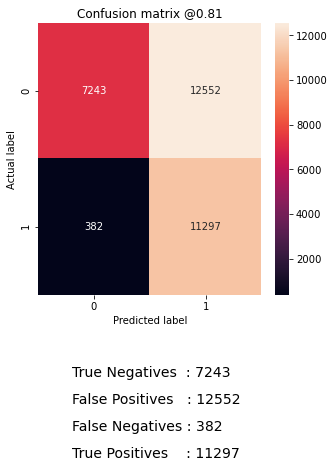

In [50]:
plot_cm(Y_test, test_predictions)

In [52]:
print(classification_report(Y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.95      0.37      0.53     19795
           1       0.47      0.97      0.64     11679

    accuracy                           0.59     31474
   macro avg       0.71      0.67      0.58     31474
weighted avg       0.77      0.59      0.57     31474



In [31]:
x = pd.DataFrame(X_train)

(175468, 164)

In [29]:
y = pd.DataFrame(Y_train)
y.reset_index(drop=True,inplace=True)

,label
0,0
1,0
2,0
3,0
4,0
...,...
175463,0
175464,0
175465,0
175466,0


In [32]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
y['label'] = y['label'].map( {0:'normal', 1:'anomaly'} )
finalDf = pd.concat([principalDf, y], axis = 1)

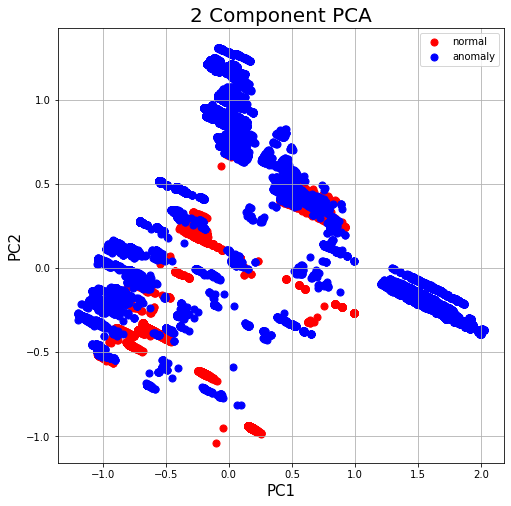

In [33]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = ['normal', 'anomaly']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1'], 
                  finalDf.loc[indicesToKeep, 'PC2'],  
                  c = color, 
                  s = 50)
ax.legend(targets)
ax.grid()